ORIGINAL CODE BLOCK FOR THE MODEL

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

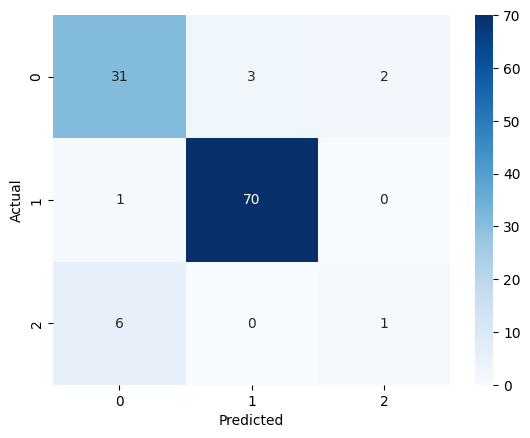

In [ ]:
# %% [code]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For preprocessing & model training
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# %% [code]
# Load the dataset
df = pd.read_csv("data.csv")

# Check first 5 rows
print(df.head())

# Check dataset info
print(df.info())

# Check missing values
print(df.isnull().sum())

# Drop unnecessary columns (like 'id' and 'Unnamed: 32')
df = df.drop(['id', 'Unnamed: 32'], axis=1)

# %% [code]
# Original labels: M (Malignant = High), B (Benign = Low)
df['diagnosis'] = df['diagnosis'].map({'M': 'High', 'B': 'Low'})

# (Optional) Introduce a "Medium" category for demonstration
# Here, we randomly assign some 'High' cases to 'Medium' for the task
import random
for i in range(len(df)):
    if df.loc[i, 'diagnosis'] == 'High' and random.random() < 0.3:  # 30% of High -> Medium
        df.loc[i, 'diagnosis'] = 'Medium'

print(df['diagnosis'].value_counts())

# Split data into features and labels
X = df.drop('diagnosis', axis=1)  # Features
y = df['diagnosis']               # Labels

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# %% [code]
# Train RandomForest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# %% [code]
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-Score: {f1:.2f}")

print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**EXTRAS ADDED TO THE CODE BLOCK TO ENHANCE THE ROBUSTNESS OF THE MODEL.**

**1. STRATIFIED SPLITTING FOR BALANCED CLASSES**:

Since there are 3 classes (High, Medium, Low), i can consider using StratifiedShuffleSplit to preserve class proportions in both train and test sets:




In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


**2. HANDLING CLASS IMBALANCE WITH SMOTE**:

Class imbalance can hurt performance on underrepresented classes like the model's custom 'Medium'. Here oversampling will be performed with SMOTE.





In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)



**3. MODEL INTERPRETABILITY**:

Random forests are great, but you can boost trust by revealing feature importance.

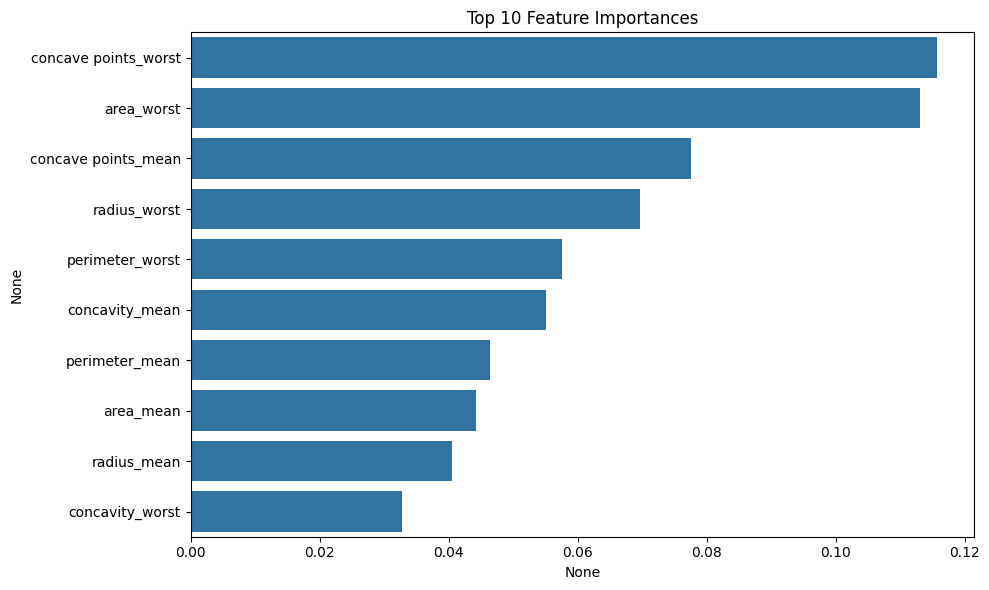

In [ ]:
importances = model.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:10], y=feat_imp.index[:10])
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()


**4. HYPERPARAMETER TUNING(GRID SEARCH)**:

Tune those forest parameters for extra performance.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42),
                    param_grid, cv=5, scoring='f1_weighted')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_



**5. CLASSIFICATION REPORT BY CLASS**:

Evaluate performance across all labels to check if “Medium” is being neglected.

In [ ]:
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))



              precision    recall  f1-score   support

         Low       0.21      0.26      0.23        31
      Medium       0.60      0.62      0.61        71
        High       0.00      0.00      0.00        12

    accuracy                           0.46       114
   macro avg       0.27      0.29      0.28       114
weighted avg       0.43      0.46      0.44       114



# ESSEMBLE OR COMPARE MODEL WITH OTHER CLASSIFIERS

I also Tried out other classifiers (e.g., XGBoost, LightGBM, or even Logistic Regression) to benchmark and potentially ensemble:

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

voting = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(random_state=42)),
    ('lr', LogisticRegression(max_iter=1000)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
], voting='soft')

voting.fit(X_train, y_train)



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:26:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                             ('lr', LogisticRegression(max_iter=1000)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

# VISUALIZING THE CLASS DISTRIBUTIONS

I want this robust model to be balanced and make informed decision by visualising the model's class distribution.

/tmp/ipython-input-8-2241279343.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='diagnosis', palette='Set2')


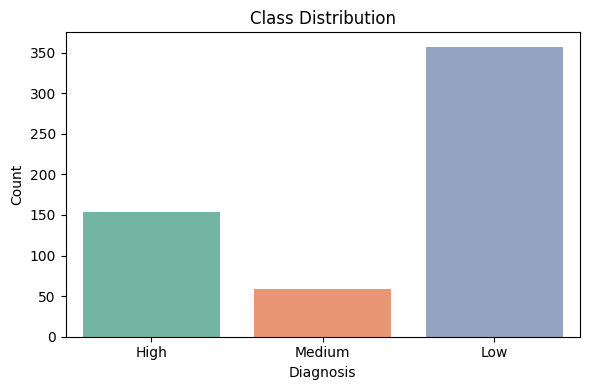

In [ ]:
# Countplot for class distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='diagnosis', palette='Set2')
plt.title('Class Distribution')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.tight_layout()
plt.show()



# TO HAVE IDEA OF THE FEATURES CLASS BY CLASS

/tmp/ipython-input-9-465908999.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='diagnosis', y='radius_mean', palette='Set3')


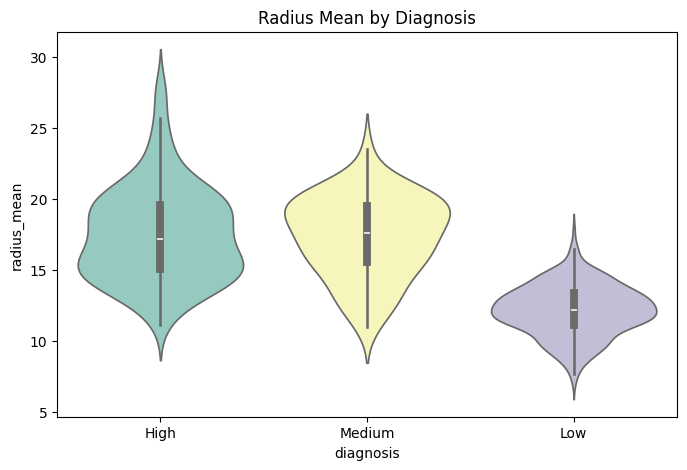

In [ ]:
# Violin plot for a feature across classes
plt.figure(figsize=(8,5))
sns.violinplot(data=df, x='diagnosis', y='radius_mean', palette='Set3')
plt.title('Radius Mean by Diagnosis')
plt.show()


# FEATURE SELECTION PIPELINE WITH RFECV

I want to pick the most important features for this model automatically using the RECURSIVE FEATURE ELLIMINATION WITH CROSS-VALIDATION mode.

Optimal number of features: 28


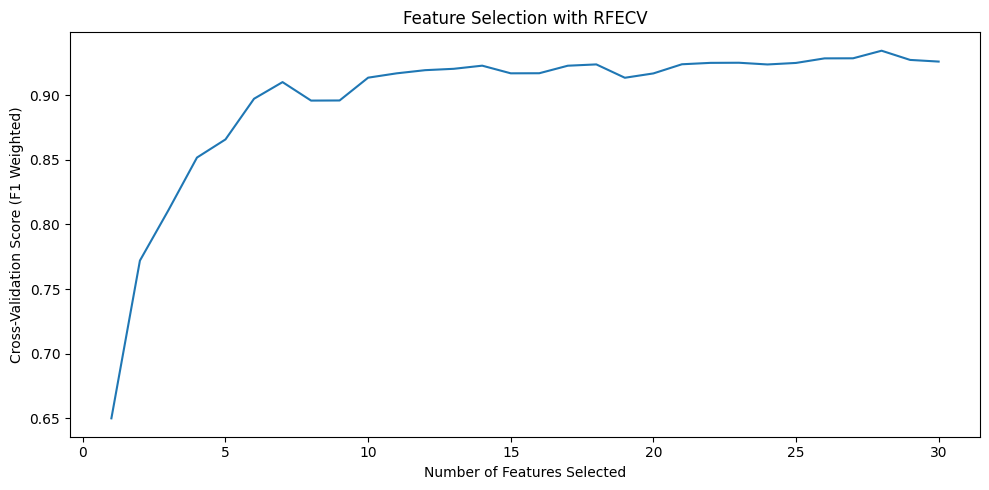

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Reuse your scaled features
estimator = RandomForestClassifier(random_state=42)
cv = StratifiedKFold(5)

selector = RFECV(estimator, step=1, cv=cv, scoring='f1_weighted', n_jobs=-1)
selector.fit(X_train, y_train)

print(f"Optimal number of features: {selector.n_features_}")

# Plot feature selection results
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['mean_test_score'])
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validation Score (F1 Weighted)")
plt.title("Feature Selection with RFECV")
plt.tight_layout()
plt.show()